A routine practice of process safety is to model scenarios for different chemical hazards present at a plant. Often there are more plausible scenarios than there is the time or resources to model at the highest level of fidelity, the more complex models take time to set up and run and often there are only so many software licenses available. There needs to be some prioritization and screening. It's fairly typical, especially for larger companies, to have screening tools that an engineer can use which incorporate simpler models and make conservative estimates to get a *first guess* at the impact of a given hazard, if this crosses a preset threshold then it is escalated to a more in depth level of modelling, drilling down to more and more detailed analysis as required.

More often than not I've seen these simple tools implemented as excel spreadsheets -- which is fine, they do the job and everybody has excel on their computers -- however overly involved spreadsheets can be rather opaque, it's often not obvious what they are doing and what assumptions are being made in those calculations. So I am going to work through an example of how one could estimate the airborne quantity, and ultimately the consequences of, an example release of butane from a large storage sphere, while documenting the assumptions and models along the way.

## The Scenario

As a simple scenario suppose a leak from a butane storage sphere. These are a fairly common sight around refineries and facilities that process large quantities of hydrocarbons. This sphere is 40ft in diameter and operates under 250psig of pressure, containing primarily n-butane, which I will assume is entirely n-butane for simplicity[^1]. As for the leak itself I am supposing a leak area equivalent to a 2in rupture[^2]. The sphere doesn't sit directly on the ground, it is supported 10ft above a concrete pad which has a diked area of 500ft². The leak itself at the bottom somewhere, suppose exactly at the bottom for simplicity[^3]. Furthermore I am assuming the release occurs on a day with an ambient temperature of 25°C and that the tank contents and surroundings are at thermal equilibrium.

**Key Assumptions**

+ Storage sphere with 40ft diameter
+ Sphere located on a concrete pad with 500ft² diked area
+ Sphere contains ~100% n-butane
+ Leak area equivalent to a 2in rupture
+ Leak located at the bottom of the vessel for maximum release pressure
+ Vessel pressure is 250psig
+ Release temperature is 25°C

::: {#fig-1}
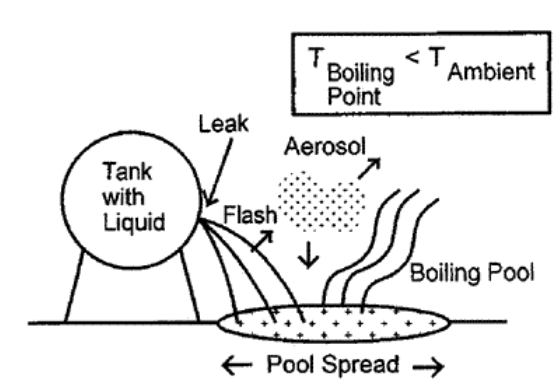\

A sketch of the release scenario, adapted from ... somewhere
:::


[^1]: If the vessel contained a mixture, for the purposes of screening, conservatively choosing the most volatile of the major components would be a reasonable assumption. These simplifications are suitable for screening purposes however if more in depth modeling is required then performing mixture flash calculations would have to be considered, which very quickly becomes a lot of work to set-up outside of a process simulator like Aspen

[^2]: There are lots of ways of generating leak scenarios, from the very specific leaks from particular propagating events to simple rules of thumb. The *Chemical Exposure Index* gives the following rules for determining a leak scenario for a vessel:
    
    A rupture based on the largest diameter process pipe attached to the vessel using the following:
    
    + For anything less than 2in a full bore rupture (i.e. the full diameter of the pipe)
    + For between 2 and 4in assume a rupture area equal to that of a 2in diameter pipe
    + For >4in assume a rupture area equal to 20% of the pipe cross section area
    
[^3]: Picking the bottom also ensures the leak occurs at the highest pressure, which gives a larger release and is most conservative. Releases at higher elevations also tend to mix more thoroughly with the air and present less of a hazard to personnel on the ground, and possibly less of an explosion hazard depending on where one supposes the ignition sources are.

In [1]:
using Unitful: ustrip, @u_str

ft = ustrip(u"m", 1u"ft")     # unit conversion ft->m
inch = ustrip(u"m", 1u"inch") # unit conversion inch->m
psi = ustrip(u"Pa", 1u"psi")  # unit conversion psi->Pa

Dᵥ = 40ft    # Diameter of the vessel, in m
Ad = 500ft^2 # Dyked area, in m^2
dₕ = 2inch   # Diameter of the hole, in m
hₗ = 50ft    # height of liquid in the vessel
hᵣ = 10ft    # height of release point

pₐ= 14.7psi     # atmospheric pressure in Pa absolute
p = 250psi + pₐ # pressure of the butane in Pa absolute
Tᵣ= 25 + 273.15; # the release temperature in K

Some relevant thermodynamic properties of butane

In [2]:
# From Perry's, 8th edition

R = 8.31446261815324 # universal gas constant, J/mol/K

# Air
MWₐᵢᵣ = 28.960
ρa(T) = (pₐ*MWₐᵢᵣ)/(R*T)/1000
μₐ(T) = (1.425e-6*T^0.5039)/(1 + 108.3/T)


# Butane
Mw = 58.122        # molar mass of butane, kg/kmol
Tcr = 425.12       # critical temperature, K
Tb = -0.6 + 273.15 # the normal boiling point of butane, K

# vapour pressure in Pa, T in K
pˢ(T) = exp(66.343 - (4363.2/T) - 7.046*log(T) + 9.4509e-6*T^2)

# density in kg/m^3, T in K
ρₗ(T) = Mw*( 1.0677/0.27188^(1+ (1-T/425.12)^0.28688) )

# heat capacity in J/kmol/K, T in K
cₚ(T) = 191030 - 1675*T + 12.5*T^2 - 0.03874*T^3 + 4.6121e-5*T^4

# latent heat in J/kmol, T in K
ΔHᵥ(T) = 3.6238e7*(1-(T/Tcr))^(0.8337 - 0.82274*(T/Tcr) + 0.39613*(T/Tcr)^2)

# surface tension, N/m
σ(T) = 0.05196*(1-(T/Tcr))^(1.2181);

The vapour pressure of butane at the release temperature is below the storage pressure, so the butane in the storage sphere will be a liquid.

In [3]:
pˢ(Tᵣ)<p

true

## The Release Rate

Since the vapour pressure within the vessel is below the storage pressure, at ambient temperature, the butane within the storage sphere is a liquid. In general one would have to account for flashing and two-phase flow during the release, however for very short discharge distances (<10cm) there is typically not enough time for the liquid to flash during discharge[see @ccps-1996 page 37 for more of a disussion on two-phase discharge rates.], over the thickness of a hole this especially true. The butane discharged from the tank will be a stream of liquid initially and the simple Bernoulli equation for a liquid jet can be used[This is also known as Toricelli's equation and can be derived from a mechanical energy balance and is found in a lot of references (e.g. *Perry's*), the form of it I'm using here comes from @ccps-1996 page 29 equation 4-10. This is really a function of time as the liquid height $h_l$ will decrease as it leaks out. Using the discharge rate at the start of the leak throughout the analysis is a conservative assumption, again for the purposes of a simplified screening case. For more detailed modeling one could make this explicitly a function of time and integrate over the release.].

$$ Q_l = c_d \rho_l A_h \sqrt{ 2 \left( p - p_a \over \rho_l \right) + 2gh_l } = c_d \rho_l { {\pi \over 4} d_h^2} \sqrt{ 2 \left( p - p_a \over \rho_l \right) + 2gh_l } $$

Where $Q_l$ is the mass flow of liquid discharged through the hole (in kg/s), $c_d$ is the discharge coefficient which can be assumed to be 0.61[From @ccps-1999 page 27, for sharp edged orifices and Reynolds numbers greater than 30,000 the discharge coefficient approaches 0.61, and the exit velocity is independent of the hole size. For a simple screening calculation one could also use a coefficient of 1.0, though that may be excessively conservative (large over-estimates end up wasting time modeling later)], $g$ is the acceleration due to gravity $9.81 m/s^2$ and the rest are as defined earlier. I am assuming, here, that the hole is circular for simplicity.

**Key Assumptions**

+ Liquid release
+ Sharp edged hole with discharge coefficient of 0.61


In [4]:
cd = 0.61
g  = 9.81 # m/s^2
Qₗ = cd*ρₗ(Tᵣ)*(π/4)*(dₕ^2)*√( 2*(p - pₐ)/ρₗ(Tᵣ) + 2*g*hₗ )

56.31092763613714

## Flashing Fraction

Since the butane is significantly above it's normal boiling point, as the liquid stream exits the storage sphere it will flash. However not all of it will flash into a vapour as the quantity that can vaporize is limited by the available energy. A simplified model of flashing is to assume the process is so rapid that it is effectively adiabatic and, from a simple steady-state energy balance, one arrives at the following[This can be easily derived, but the form given here is from @ccps-1996 page 31, equation 4-14]

$$f_v = {Q_v \over Q_l} = { {c_p (T_r - T_b)} \over {\Delta H_v} }$$

where $f_v$ is the mass fraction that flashes and $Q_v$ is the mass flow of liquid that flashes (in kg/s) and recall that the heat capacity and latent heat are functions of temperature.

**Key Assumptions**

+ flashing occurs rapidly and is effectively adiabatic
+ heat capacity and latent heat taken at the release temperature


In [5]:
fᵥ = cₚ(Tᵣ)*(Tᵣ-Tb)/ΔHᵥ(Tᵣ) 

0.17128269541302374

In [6]:
Qᵥ(t) = fᵥ*Qₗ

Qᵥ (generic function with 1 method)

## Aerosol Fraction

As the butane flashes into a gas, some of the liquid stream will be entrained as an aerosol. The presence of aerosolized droplets are a major contributor to the overall mass of a vapour cloud and it is important to include them. There is a wide array of methods for estimating the aerosolized fraction, from as simple as assuming it is 1-2x the flashed fraction to more detailed models that take into account the different mechanisms behind aerosolization and rain-out.

The aerosol fraction, $f_a$, the fraction of the liquid remaining in the cloud after flashing, in the form of aerosolized droplets.

$$ f_a = {Q_a \over { Q_l - Q_v } }$$

One method is to estimate the droplet size and from that determine the degree of rain out (i.e. the liquid that *does not* remain in the cloud) through a model of droplet settling. I am going to use the RELEASE model[@johnson-1999] of droplet settling to determine the aerosol fraction.

**Key Assumptions**

+ rain-out is the only significant mechanism by which liquid drops out to form a pool
+ all droplets larger than a critical size drop out, all droplets below that size remain in the cloud
+ evaporation is negligible
+ the RELEASE model is used to estimate the degree of rain-out

### Mean droplet diameter
There are three important mechanisms of drop formation, capillary breakup which occurs when sub-cooled liquids are discharged through very small holes (<2mm), aerodynamic breakup which occurs with larger holes with sub-cooled liquids or slightly super-heated liquids, and flashing breakup which occurs as super-heated liquids are discharged and flash to vapour in the form of bubbles which breakup the surrounding liquid.

Aerodynamic breakup is correlated with the Weber number, which is the ratio of shear forces on the surface of the liquid to the surface tension.

$$ We = { { \rho_g u_d^2 d_p } \over \sigma } $$

Where $\rho_g$ is the density of the gas, $u_d$ the discharge velocity, $d_p$ the mean droplet diameter, and $\sigma$ the surface tension. Experimentally, droplet breakup occurs at a critical Weber number between 12 and 22, and so the mean droplet size can be estimated by rearranging[@woodward-1998 page 49]

$$ d_p = { { \sigma We_c } \over {\rho_g u_d^2 } } $$

and solving at the critical Weber number $We_c = 12$, assuming $\rho_g = \rho_a$ to be the density of ambient air, and with the discharge velocity $u_d$ given as:

$$ u_d = { Q_l \over { c_d A_h \rho_l} } = { Q_l \over {c_d \frac{\pi}{4} d_h^2 \rho_l} }$$

In [7]:
# the cloud temperature, assumed to be the boiling point
Tc = Tb

# critical Weber number
We = 12                                  

# release velocity, m/s
ud = Qₗ/( cd * (π/4)*dₕ^2 * ρₗ(Tᵣ)) 

# droplet size, m, due to aerodynamic breakup
da = ( σ(Tc) * We)/(ρa(Tc) * ud^2)  

2.188550597862162e-5

The diameter of droplets from flashing breakup can be calculated from the following empirical correlation[@woodward-1998 page 50] and the mean droplet diameter is simply the smallest of either the aerodynamic or flashing diameter[@johnson-1999 page 64] In almost all cases that are relevant for release modelling capillary breakup is not significant.

$$ d_p = { {0.03} \over {10 + 4.0 \cdot (T - T_b) } }$$

::: {#fig-2}
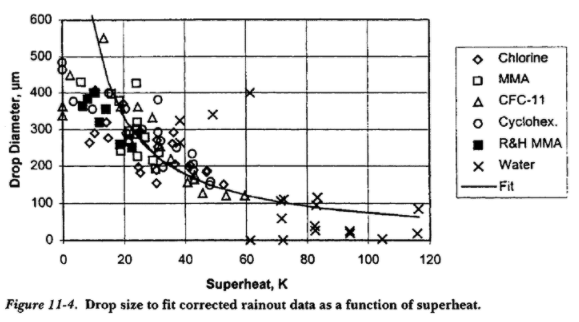\

A correlation for droplet size due to flashing breakup.
:::

In [8]:
# droplet size, m, due to flashing breakup
df = (0.03)/(10 + 4*(Tᵣ-Tb))                   

dₚ = min(da, df)

2.188550597862162e-5

### The RELEASE model

The RELEASE model uses a distribution of droplet sizes to determine, based on a simple model of settling dynamics, the fraction of droplets that remain the cloud. The model assumes droplet diameter follows a log-normal distribution and that any droplet greater than a *critical diameter*, determined from a balance of drag and buoyancy, will rain out. The parameters of the model were fit to experimental data of rain out events.

#### Critical diameter 

The critical diameter is a function of a *critical velocity* which is calculated from a model of the spray jet with a tuning parameter $\beta$ which captures the expansion of the jet. The default value for $\beta$ is given to be 4.46° [@johnson-1999 page 63]

$$ u_c = u_d \tan \beta $$

In [9]:
# the default value given by RELEASE is 4.46°
β = deg2rad(4.46)
uc = ud * tan(β) # critical velocity, m/s

6.197367132394693

The critical diameter is found by solving the balance of buoyant and drag forces on a droplet

$$ F_{buoyant} = F_{drag} $$

$$ \left( \rho_l - \rho_g \right) g V_{droplet} = \frac{1}{2} C_D \rho_g u_c^2 A_{droplet} $$

$$ \left( \rho_l - \rho_g \right) g \cdot \frac{\pi}{6} d_c^3 = \frac{1}{2} C_D \rho_g u_c^2 \cdot \frac{\pi}{4} d_c^2 $$

$$ \left( \rho_l - \rho_g \right) g \cdot d_c - \frac{3}{4} C_D \rho_g u_c^2 = 0$$

Where $C_D$ is the drag coefficient, which for a solid sphere in viscous flow is given by this correlation[@white-1974. This could be an opportunity for improvement to the RELEASE model as liquid droplets and bubbles do not experience drag in the same way as solids, due to internal flows that can dissipate energy]

$$ C_D = 0.4 + {24 \over Re} + {6 \over {1 - \sqrt{Re} } } $$

with the Reynolds number $Re$ as


$$ Re = { {\rho_g u_c d_c} \over \mu_a} $$

for simplicity the gas density $\rho_g$ can be calculated assuming an ideal gas, and $\mu_a$ is the viscosity of air.

This relationship will have to be solved numerically to get the critical diameter, since the Reynolds number and thus drag coefficient is a function of the critical diameter. Which is fairly straight forward and in this case I use the bounds $0.1 \cdot d_p \le d_c \le 10 \cdot d_p$ as a very broad starting point.


In [10]:
using Roots: find_zero

ρg(T) = (pₐ * Mw)/(R * T)/1000  # ideal gas law, kg/m^3

# the Reynold's number at the release temperature
Re(d) = ρg(Tc) * uc * d / μₐ(Tc)

# the drag coefficient
CD(d) = 0.4 + (24/Re(d)) + 6/(1-√(Re(d))) 

# critical diameter
dc = find_zero( d ->   (ρₗ(Tc) - ρg(Tc))*g*d - 0.75*CD(d)*ρg(Tc) * uc^2, (0.1*dₚ, 10*dₚ))

0.00014250630981793824

#### Aerosol Fraction

The aerosol fraction, in the RELEASE model, is the mass fraction of droplets with a diameter less than the critical diameter:

$$ f_a = { {F_m \left( d_c \right)} \over {F_m \left( \infty \right)} } $$

Where $F_m(d)$ is the cumulative mass distribution function for droplets. This is based on a log-normal distribution and is given as

$$ F_m \left( d \right) = \left( \frac{\pi}{6} \rho_l d_p^3 \right) \int_0^t { t^2 \over {\sqrt{2 \pi} \log{\sigma_G} } } {\exp \left( -\frac{1}{2} \left( \log{t} \over \log{\sigma_G} \right)^2 \right)} dt$$

Where $t = d/d_p$ and $\sigma_G$ is another tuning parameter (the default value given is 1.8).

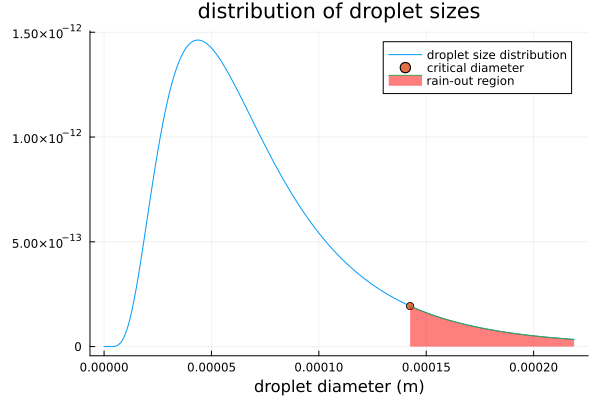

In [11]:
#| echo: false
#| label: fig-3
#| fig-cap: "The distribution of droplet sizes and rain-out region."
using Plots

σG = 1.8
m_dist(d) = ((π/6)*ρₗ(Tc)*dₚ^3) * ((d/dₚ)^2/ (√(2*π)*σG)) * exp(-0.5*(log(d/dₚ)/log(σG))^2)
plot(m_dist, 0, 10*dₚ, title = "distribution of droplet sizes", xlabel = "droplet diameter (m)", lab = "droplet size distribution", leg = :topright)
plot!([dc], [m_dist(dc)], seriestype = :scatter, lab = "critical diameter")
plot!(m_dist, dc, 10*dₚ, fill = (0, 0.5, :red), lab = "rain-out region")

With a change of variables $z = \log{t}$ and $s = \log{\sigma_g}$ the cumulative mass distribution function [can be integrated](https://www.wolframalpha.com/input/?i=integrate+%281%2F%28sqrt%282*pi%29*s%29%29*exp%283z%29*exp%28-%281%2F2%29*%28z%2Fs%29%5E2%29+dz):

$$ F_m \left( d \right) = \left( \frac{\pi}{6} \rho_l d_p^3 \right) \int_{-\infty}^z { 1 \over {\sqrt{2 \pi} s} }{\exp \left( 3z \right) \exp \left(-\frac{1}{2} \left( z \over s \right)^2 \right)} dz $$

$$ = \left( \frac{\pi}{6} \rho_l d_p^3 \right) \frac{-1}{2} \exp \left( 9s^2 \over 2 \right) \left[ \mathrm{erf} \left( {3s^2 - z} \over {\sqrt{2} s} \right) \right]_{-\infty}^z$$

$$= \left( \frac{\pi}{6} \rho_l d_p^3 \right) \exp \left( 9 \left( \log{\sigma_G} \right)^2 \over 2 \right) \times \frac{1}{2} \left[ 1 - \mathrm{erf} \left( {3 \left( \log{\sigma_G} \right)^2 - \log{d} + \log{d_p} } \over {\sqrt{2} \log{\sigma_G} } \right) \right] $$

where $\mathrm{erf}\left( x \right)$ is the error function. Finally the aerosol fraction is[@johnson-1999 pages 58-60. The integration is not shown in the text, but the fortran code is included on the CD if one wants to verify the final result.]:

$$ f_a = { {F_m \left( d_c \right)} \over {F_m \left( \infty \right)} } = \frac{1}{2} \left[ 1 - \mathrm{erf} \left( {3 \left( \log{\sigma_G} \right)^2 - \log{d_c} + \log{d_p} } \over {\sqrt{2} \log{\sigma_G} } \right) \right]$$

The RELEASE code uses this formula and also does a check for extreme cases, defaulting to either 1 or 0.

In [12]:
using SpecialFunctions: erf

function RELEASE_fa(dc, dp; σG=1.8)
    if (dp/dc) >= exp(σG)
        # checks for where erf(x) ~ 1
        return 0.0
    elseif (dc/dp) >= 15*exp(σG)
        # checks for where erf(x) ~ -1
        return 1.0
    else
        return 0.5*( 1 - erf((3*log(σG)^2 -log(dc) + log(dp)) / (√(2) * log(σG)) ))
    end
end

RELEASE_fa (generic function with 1 method)

In [13]:
fₐ = RELEASE_fa(dc, dₚ)  # calculates the aerosol fraction using the RELEASE method

0.9227949810754577

In [14]:
Qₐ(t) = fₐ*(Qₗ - Qᵥ(t));

## Pool Evaporation

The droplets that rain out of the cloud will form a pool and, depending on how long the release occurs, evaporation from the pool can be a significant contributor to the overall airborne quantity. In this case the liquid is assumed to be at the boiling point of butane, it cooled through evaporative cooling, and is cryogenic with respect to the ground. There are two major factors that impact the evaporation rate: the area of the pool and the heat transfer into the pool from the environment. Both of these, in general, can be quite complicated time-dependent phenomena with lots of different models capturing a wide array of scenarios.

Since this is a simple screening calculation, I will be avoiding all of that and use some simple models for pool spread and evaporative flux.

**Key Assumptions**

+ Simple model of pool spread
+ Evaporation of pool is driven by heat transferred from the ground by conduction

A simple model of pool spread as a function of time is[@woodward-1998 page 57]

$$ A_{pu}  = \frac{\pi}{4} \sqrt{\frac{2048}{81} {Q_{p} \over \rho_l} t^3} $$

Where $A_{pu}$ is the unconstrained pool area in m², $t$ is the time since the start of the release in seconds, and $Q_{p}$ is the mass flow of liquid to the pool in kg/s (the total release rate less what was lost to flashing and entrained in the cloud as an aerosol)

$$ Q_{p} = Q_l - Q_v - Q_a $$

In practice the area of the pool will be limited to be at most the diked area. For large spills having a diked area is significant, both in the obvious containing of the spill, but also since it can significantly reduce the amount of pool evaporation.

In [15]:
# the liquid temperature, taken to be the boiling point
Tₗ = Tb

# mass flow to the pool, kg/s
Qₚ(t) = Qₗ - Qᵥ(t) - Qₐ(t)

# unconstrained pool area, m^2
Aₚᵤ(t) = (π/4) * √((2048/81) * (Qₚ(t)/ρₗ(Tₗ)) * t^3 )

# Pool area, restricted to at most dyked area, m^2
Aₚ(t) = min( Aₚᵤ(t) , Ad);

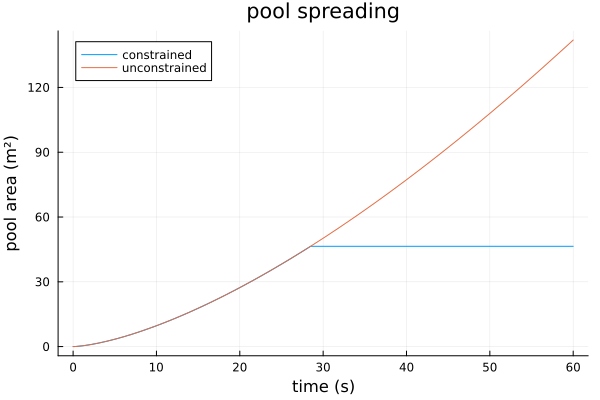

In [16]:
#| echo: false
#| label: fig-4
#| fig-cap: "Pool spreading as a function of time for constrained and unconstrained releases."

plot([Aₚ, Aₚᵤ], 0, 60, 
     title = "pool spreading", 
     xlabel = "time (s)", 
     ylabel="pool area (m²)", 
     lab = ["constrained" "unconstrained"], 
     leg = :topleft)

In general the evaporation rate is derived from a heat balance accounting for the heat transfer from the ground, from the ambient air, and from solar flux, however in this case a simplifying assumption is that the majority of the heat transferred to the liquid is from the ground.

For a cryogenic liquid spilled on land a simple model of the evaporative flux $G_e$ in kg/s/m² is[@ccps-1999 page 63]

$$ G_e = { {Mw} \over {\Delta H_v} } { k \left( T_s - T_l \right) \over \sqrt{\pi \alpha t} } $$

Where $k$ is the thermal conductivity of the surface (ground) in W/m/K, $T_s$ is the temperature of the surface in K, $T_l$ the temperature of the liquid in K, and $\alpha$ the thermal diffusivity of the surface in m²/s

The overall evaporation rate is the product of the pool area and the evaporative flux

$$ Q_e \left( t \right) = G_e \left( t \right) \cdot A_p \left( t \right) $$

It's worth taking a moment to note that the evaporative flux will decrease with time. This is because the ground under the spill cools down over time. The overall evaporation rate will grow as the pool grows -- in this model the pool grows $\propto t^{3/2}$ while the flux decreases  $\propto t^{-1/2}$, so the evaporation rate should grow $\propto t$ -- but once it hits the limit of the diked area the overall evaporation rate will decrease over time.

One thing worth noting is that the pool area equation does not take into account a mass balance. As time goes on the unconstrained pool only grows, even if the evaporation rate were to exceed the rate of new liquid being added to the pool. This limitation probably doesn't matter for short duration leaks in which it is expected that the pool evaporation rate is strictly lower than the rate at which new liquid is added to the pool, however for long duration spills or instantaneous spills this not appropriate and a more complex model of pool growth and evaporation should be considered.


In [17]:
# Thermal properties of concrete 
# A. Bejan, Kraus, A. D., Heat Transfer Handbook, John Wiley & Sons, 2003
k = 1.28     # W/m/K
α = 6.6e-7   # m^2/s

# surface temperature, taken to be the ambient temperature
Tₛ = Tᵣ      

# evaporative flux, kg/s/m^2
Gₑ(t) = (Mw/ΔHᵥ(Tₗ)) * k * (Tₛ - Tₗ) / √(π*α*t)

# evaporation rate, kg/s
Qₑ(t) = min( Gₑ(t)*Aₚ(t), Qₚ(t));

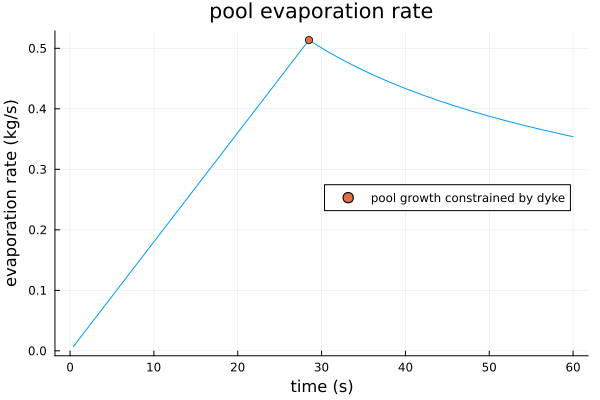

In [18]:
#| echo: false
#| label: fig-5
#| fig-cap: "The pool evaporation rate as a function of time for a constrained release."

tdyke = find_zero(t -> Aₚᵤ(t) - Ad, (0, 60))

plot(Qₑ, 0, 60, lab=false)
plot!([tdyke], [Qₑ(tdyke)], seriestype = :scatter, lab = "pool growth constrained by dyke")
plot!( title = "pool evaporation rate", 
       xlabel = "time (s)",
       ylabel="evaporation rate (kg/s)", 
       leg = :right)

## Airborne Quantity

The total airborne quantity is the sum of the flashed vapour, the aerosolized droplets, and the vapour from pool evaporation. So far the calculation has been in terms of *rates*, but the *total* airborne quantity depends upon the release duration, $t_d$. There are lots of different ways of deciding on a release duration, in general the release duration of interest is the time it would take for a vapour cloud to find an ignition source -- for vapour cloud explosion scenarios -- or, more optimistically, the time it would take for the plant to respond and take some action to mitigate the hazard. A common default release duration is 10 minutes[#ccps-1999 page 22]

One common simplification is to take the vapour and aerosol rates to be a constant, and the pool evaporation rate as a constant at the final time $t_d$, then multiply by the total duration. An alternative is to integrate over time from 0 to $t_d$.

$$ Q_{aq} \left( t \right) = Q_v \left( t \right) + Q_a \left( t \right) + Q_e \left( t \right)$$

$$ m_{aq} = \int_0^{t_d} Q_{aq} \left( t \right) dt = \int_0^{t_d} Q_v \left( t \right) + Q_a \left( t \right) + Q_e \left( t \right) dt $$

One could try to integrate this analytically, but for re-useability of code it's a better idea to integrate numerically -- then different models for each of the rates can be swapped in and out with ease.

In [19]:
using QuadGK: quadgk

# release duration of 10 minutes, seconds
td = 10*60 

# total airborne release rate is the sum of the individual 
# mechanism release rates, in kg/s
Qaq(t) = Qᵥ(t) + Qₐ(t) + Qₑ(t) 

# total airborne quantity is the integral over time
maq, err = quadgk(Qaq, 0, td)  

(31737.218210630548, 0.00014433872246399915)

A quick sanity check is to make sure that the total airborne quantity is less than the total quantity released, i.e. $Q_l \cdot t_d$.

In [20]:
maq <= Qₗ*td

true

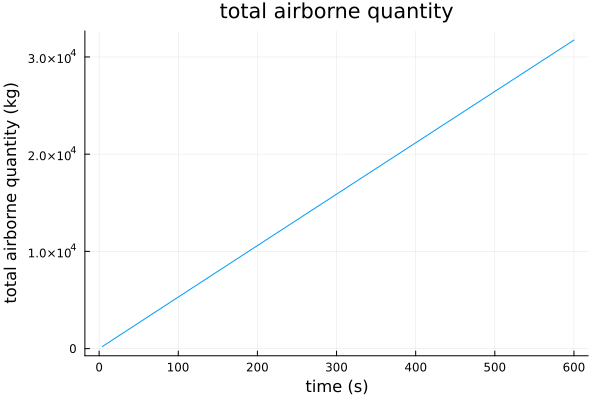

In [21]:
#| echo: false
#| label: fig-6
#| fig-cap: "The total airborne quantity as a function of time."

plot(t -> quadgk(Qaq, 0, t)[1], 0, td)
plot!(title = "total airborne quantity", 
      xlabel = "time (s)", 
      ylabel = "total airborne quantity (kg)", 
      leg=false)

It is often insightful to compare the airborne quantity to the case where there was no secondary containment, i.e. the pool could expand without bound.

In [22]:
Qₑᵤ(t) = min( Gₑ(t)*Aₚᵤ(t), Qₚ(t))
Qaqu(t) = Qᵥ(t) + Qₐ(t) + Qₑᵤ(t)

maqu, err = quadgk(Qaqu, 0, td)

(33426.49125139247, 0.0003172098610093599)

In [23]:
#| echo: false

using Printf

@printf "With secondary containment    %0.3f t \n" maq/1000
@printf "Without secondary containment %0.3f t \n" maqu/1000

With secondary containment    31.737 t 
Without secondary containment 33.426 t 


In this case the secondary containment reduced the overall airborne quantity by ~5%, and we wouldn't expect it to be hugely important for this example as most of the mass of the vapour cloud came from the flashing of the liquid immediately upon release and from entrained droplets.

## Closing Remarks

There are always trade offs to be made with model accuracy, model complexity, and the shear amount of data required to run the models (often overlooked unless you're the flunky tasked with finding all of these constants). This notebook aimed at creating a simple screening model and made several simplifications along the way. One thing I tried to avoid, though, is the use of gross "rules of thumb" and any pre-calculating of constants. I see this fairly often in older works because, likely, the calculations were being done by hand and this greatly speeds that up. I don't think the justification for it is still valid, though, for a few reasons. For one many very rough rules of thumb were developed to avoid iterative solutions, but with modern computers there's really no reason to, the numerical solutions in this notebook took fractions of a second to calculate on my laptop. For another much of the work collecting constants and pre-calculating things simply makes it harder to validate formulas. With a notebook like this not only can I properly typeset the formula more-or-less as presented in the reference (while keeping a consistent nomenclature) but I can also fairly transparently type that into Julia, making it very clear what the code is doing, step by step, and where those formulae came from. This should make it very easy to verify that I haven't made a typo, for example. In my experience with some older excel tools that used a lot of pre-calculated rearranged equations, it was often entirely not obvious how the reference (if there is one given at all) lead to the final equations in the spreadsheet and verifying that the spreadsheet worked as intended without some written down derivation could take hours.

One feature that I didn't use, but could be a nice addition, is the unit-aware library `Unitful`, I included it at the beginning for some unit conversions. However it can be used to track the units for each number throughout, ensuring that results are in the appropriate units and that there are no unit mismatches. I did not use that part of things because there are quite a few correlations and figuring out the appropriate units for the various constants in those correlations such that all the units match properly can be a pain in the butt. In general, though, using `Unitful` is a very powerful tool when working with physical modelling.

That said, this notebook is far from perfect. Probably the biggest simplification that could be changed is the assumption that the liquid release rate is a constant and is at the highest rate. This could be made a function of time -- as the vessel empties there is less hydro-static pressure -- and the rates of flashing and aerosol entrainment made explicitly time dependent as well. Like all things this would take some time to implement -- though not much -- and would improve model performance for long duration releases. The assumption made is on the conservative side and for short duration, and large vessels, is appropriate for screening purposes. Though, like all things with code, you only have to put the effort in once...

For re-useability the lowest hanging fruit for changes would be to link this to a database of substance properties. Probably the most tedious part of using this notebook is finding and filling in all of the correlations at the beginning for the various temperature dependent material properties. There's no reason why a small database couldn't be set up, containing everything in a given plant's inventory, and some code added so the notebook can look up the properties for you.

There are also lots of opportunities for embedding some of the decision logic into the notebook, I set up the notebook to do a liquid discharge because I knew what the scenario was. Furthermore I knew that the boiling point of butane is less than ambient and so the pool evaporation would be for a cryogenic liquid spill. There's no reason why the logic behind those decisions, and others, couldn't be generalized and the notebook setup to choose which model was appropriate in a clear and transparent way.


## References
::: {#refs}
:::